In [14]:
%reset -f

In [15]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io as reader
from matplotlib import pyplot as plt 
import utils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.iter = 0
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [17]:
def get_liddriven_data(ld_file):
    nx = 100
    ny = 100
    x = np.linspace(0.0, 1.0, nx)
    t = np.linspace(0.0, 1.0, ny)
    X, Y = np.meshgrid(x, t)

    u_ref = np.genfromtxt(ld_file[0], delimiter=',')
    v_ref = np.genfromtxt(ld_file[1], delimiter=',')
    usol = np.sqrt(u_ref ** 2 + v_ref ** 2)

    x_test_np = np.concatenate((np.hstack(X.T).reshape(-1, 1), 
                                np.hstack(Y.T).reshape(-1, 1)), 
                                axis=1)
    
    x = torch.from_numpy(x).float().to(device)
    t = torch.from_numpy(t).float().to(device)
    x_test = torch.from_numpy(x_test_np).float().to(device)
    x_test_exact = torch.from_numpy(usol).float().reshape(-1, 1).to(device)
    return x, t, x_test, x_test_exact

In [18]:
x, t, x_test_point, x_test_exact = get_liddriven_data(['u.csv', 'v.csv'])
Exact = x_test_exact.cpu().detach().numpy().reshape(100, 100)

In [19]:
net = Net([2, 20, 20, 20, 20, 20, 3]).to(device)
net.load_state_dict(torch.load('./best_model.pth'))

<All keys matched successfully>

In [20]:
from pyDOE import lhs
lb = np.array([0.0, 0.0])
ub = np.array([1.0, 1.0])
def random_fun(num):
    temp = torch.from_numpy(lb + (ub - lb) * lhs(2, num)).float().to(device)
    return temp

In [21]:
out = net(x_test_point)
imgl_u, imgl_v, imgl_p = out[:, [0]], out[:, [1]], out[:, [2]]
imgl_fltn = torch.sqrt(imgl_u ** 2 + imgl_v ** 2)
imgl = imgl_fltn.reshape([100, 100])

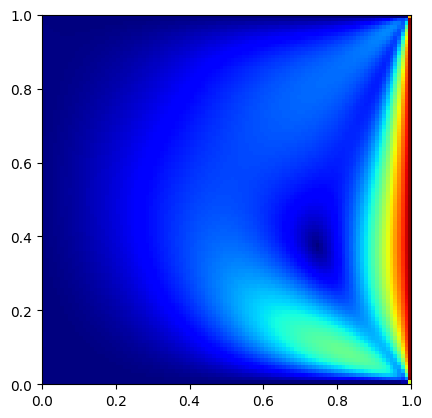

In [27]:
plt.imshow(imgl.cpu().detach().numpy(), cmap='jet', interpolation='nearest', extent=[0, 1, 0, 1])

In [22]:
j0 = 0
J = 5
e = 0.01

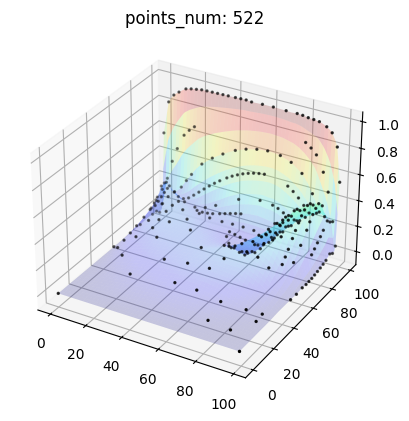

<Figure size 640x480 with 0 Axes>

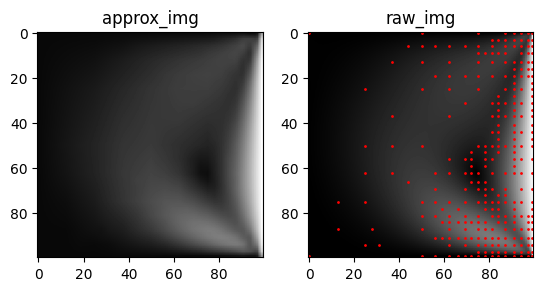

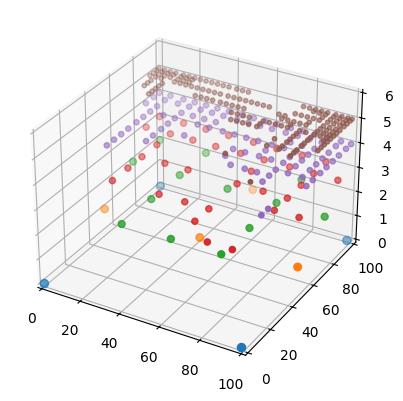

In [23]:
xc1 = torch.arange(lb[1], ub[1], 1/imgl.shape[0]).reshape((-1,1)).to(device)
xr1 = torch.arange(lb[0], ub[0], 1/imgl.shape[1]).reshape((-1,1)).to(device)
iwtmodel = utils.torchIWT(j0, J, e).to(device)
approx, indicies = iwtmodel.get_Iwt2d(imgl, xc1, xr1)
l=-1
utils.show_approx(imgl.cpu().detach().numpy(), approx.cpu().detach().numpy(), indicies, level_points=l, s=1, cmap='gray', show_2d_points=True, al=0.2)
utils.show_3d_points(approx.cpu().detach().numpy(), indicies, level_points=l)

In [24]:
err = np.linalg.norm(imgl.cpu().detach().numpy() - Exact, 2) / np.linalg.norm(Exact, 2) 
print('Relative L2 error: {:.4e}'.format(err))

Relative L2 error: 4.1468e-02


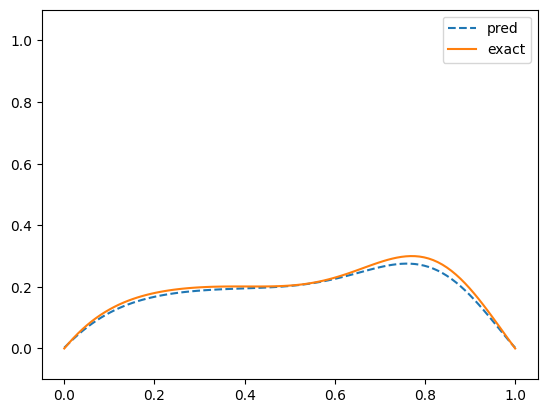

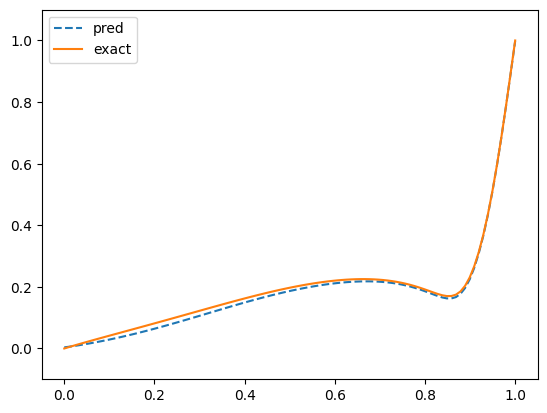

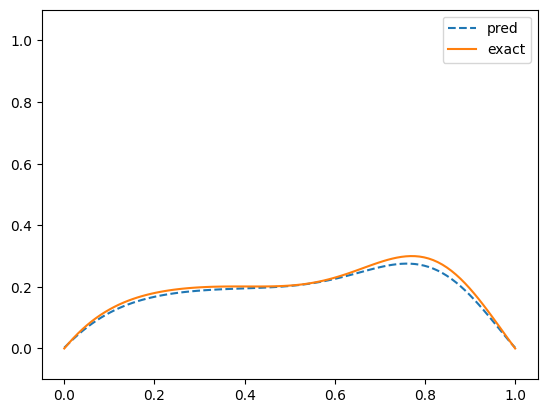

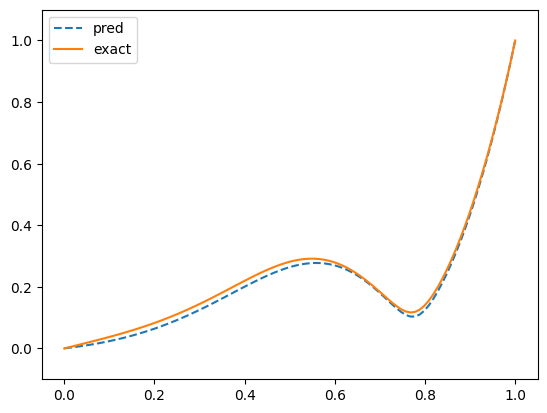

In [25]:
out = net(x_test_point)
imgl_u, imgl_v, imgl_p = out[:, [0]], out[:, [1]], out[:, [2]]
imgl_fltn = torch.sqrt(imgl_u ** 2 + imgl_v ** 2)
x_test_pred = imgl_fltn.reshape([100, 100])
x_test_pred = x_test_pred.reshape(x.shape[0], t.shape[0])
x_test_pred = x_test_pred.to('cpu').detach().numpy()
x_test_exact = x_test_exact.reshape(x.shape[0], t.shape[0])
x_test_exact = x_test_exact.to('cpu').detach().numpy()
x1 = x.cpu().detach().numpy()
t1 = t.cpu().detach().numpy()

rc1 = 0.5
rc2 = 0.3
rc3 = -0.5
rc4 = -0.3

plt.figure()
plt.plot(x1, x_test_pred[:, int((rc1) / (1 / 100))], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, int((rc1) / (1 / 100))], label='exact')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.figure()
plt.plot(x1, x_test_pred[int((rc2) / (1 / 100)), :], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[int((rc2) / (1 / 100)), :], label='exact')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.figure()
plt.plot(x1, x_test_pred[:, int((rc3) / (1 / 100))], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, int((rc3) / (1 / 100))], label='exact')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.figure()
plt.plot(x1, x_test_pred[int((rc4) / (1 / 100)), :], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[int((rc4) / (1 / 100)), :], label='exact')
plt.ylim([-0.1, 1.1])
plt.legend()

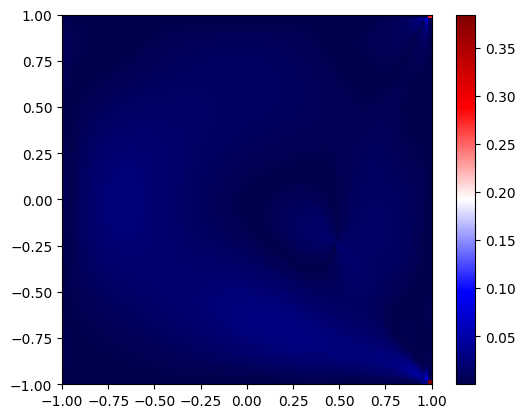

In [26]:
# error
plt.imshow(np.abs(x_test_pred - x_test_exact), extent=(-1, 1, -1, 1), cmap='seismic')
# 颜色条
plt.colorbar()
plt.show()